In [1]:
import os
from typing import Dict, Optional
from utils import train, test
from metrics import Summary, Metrics
from matplotlib.pyplot import figure, show, savefig
from matplotlib.axes import Axes

def plot(metrics: Dict[str, Metrics], metric: str, ax: Optional[Axes] = None):
    ax_none = False
    if ax is None:
        plot = figure()
        ax = plot.add_subplot()
        ax_none = True

    for key, value in metrics.items():
        ax.plot(value.history[metric], label=key)
    
    ax.legend()
    ax.set_title(metric)
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)

    if ax_none:
        show()

def run_experiment(model, optimizer, criterion, device: str, data, summary: Summary, epochs: int = 30):
    summary.open()
    summary.add_text('model', str(model))
    summary.add_text('optimizer', str(optimizer))
    summary.add_text('criterion', str(criterion))

    for epoch in range(epochs):
        train(model, criterion, optimizer, data['train'], summary.metrics['train'], device)
        test(model, criterion, data['test'], summary.metrics['test'], device)

    summary.close()

    metrics_plot = figure(figsize=(10, 5))
    metrics_plot.suptitle(f'{summary.name}')
    ax = metrics_plot.add_subplot(1, 2, 1)
    plot(summary.metrics, 'loss', ax)

    ax = metrics_plot.add_subplot(1, 2, 2)
    plot(summary.metrics, 'accuracy', ax)
    show()

In [2]:
from torch import Tensor
from torch.nn import Module, Sequential, Linear, ReLU, Flatten
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

class Net(Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.layers = Sequential(
            Linear(28*28, 512),
            ReLU(),
            Linear(512, 10),
        )
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.flatten(x)
        x = self.layers(x)
        return x

Running experiment Net with id 17846fe1-33d2-446a-843c-dd942c0b9e41
Tensorboard logs are saved in logs/Net-17846fe1-33d2-446a-843c-dd942c0b9e41
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: OptimizedModule(
  (_orig_mod): Net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=10, bias=True)
    )
  )
)
----------------------------------------------------------------
optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
----------------------------------------------------------------
criterion: CrossEntropyLoss()
-------------------------------------------------------

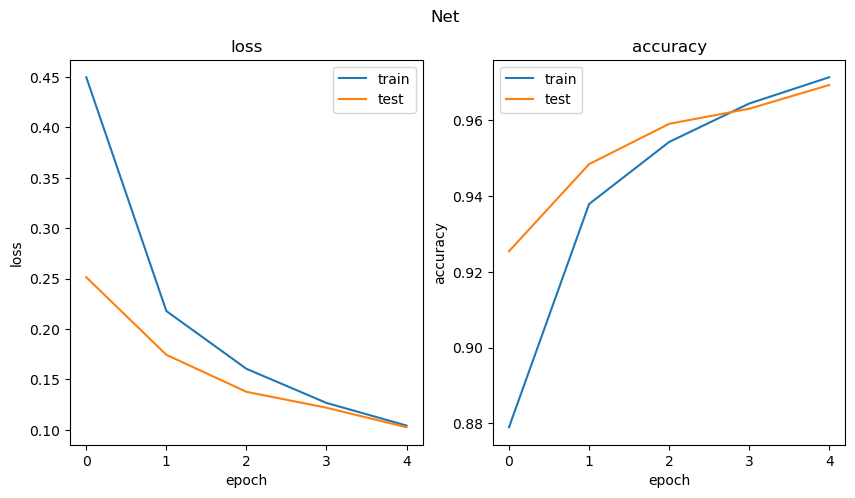

In [3]:
from uuid import uuid4
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from metrics import Summary, Metrics

device = 'cuda'
loaders = {
    'train': DataLoader(MNIST(root='./data', train=True, download=True, transform=ToTensor()), batch_size=64, shuffle=True, pin_memory=True, pin_memory_device=device, num_workers=4),
    'test': DataLoader(MNIST(root='./data', train=False, download=True, transform=ToTensor()), batch_size=64, shuffle=False, pin_memory=True, pin_memory_device=device)
}

torch.set_float32_matmul_precision('high')

experiment = uuid4()
model = Net().to(device)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
compiled = torch.compile(model)

summary = Summary(name=model.__class__.__name__, id=experiment)
run_experiment(compiled, optimizer, criterion, device, loaders, summary, epochs=5)
